# A Basic MCMC Implementation

### Imports + Looks!
---

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
from tqdm import tnrange, tqdm_notebook
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
from IPython.display import display, HTML, Latex
display(HTML("<style>.container { width:95% !important; }</style>"))

### A Basic Example
---

In [8]:
# Set up the known probabilities based on prior knowledge.
# Define the transition matrix.
# Rows represent the current state.
# Columns are the next state.
# FOGGY SUNNY RAINY
FOGGY = np.array([0.5, 0.25, 0.25])
SUNNY = np.array([0.5, 0, 0.5])
RAINY = np.array([0.25, 0.25, 0.5])
# Define the parameter space.
parameter = np.array(["Foggy", "Sunny", "Rainy"])
P = np.array([FOGGY, SUNNY, RAINY])
print(P)

[[0.5  0.25 0.25]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.5 ]]


P( Foggy , Sunny , Rainy ) in 1 day = [ 0.500 0.250 0.250 ]
P( Foggy , Sunny , Rainy ) in 5 day = [ 0.400 0.200 0.399 ]
P( Foggy , Sunny , Rainy ) in 24 day = [ 0.400 0.200 0.400 ]


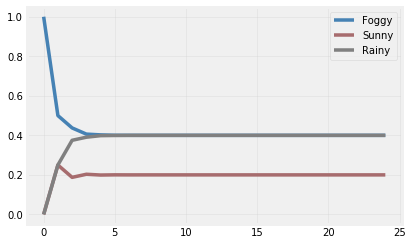

In [9]:
# Set the prediction length and the initial parameter value.
Prediction_Days = 25
CurrentStateProb = [[0, 0, 0]] * Prediction_Days
CurrentStateProb[0] = [1, 0, 0] # Today is foggy
# Run the Markov chain.
for i in range(1, Prediction_Days):
    # Current parameter value times probability
    Prob = np.matmul(CurrentStateProb[i-1], P)
    CurrentStateProb[i] = list(Prob)
# print(CurrentStateProb)
# Print weather predictions.
print("P(", parameter[0], ",", parameter[1], ",", parameter[2], ") in 1 day = [ ", end="")
for value in CurrentStateProb[1]:
    print("{:.3f} ".format(value), end="")
print("]")
print("P(", parameter[0], ",", parameter[1], ",", parameter[2], ") in 5 day = [ ", end="")
for value in CurrentStateProb[5]:
    print("{:.3f} ".format(value), end="")
print("]")
print("P(", parameter[0], ",", parameter[1], ",", parameter[2], ") in 24 day = [ ", end="")
for value in CurrentStateProb[24]:
    print("{:.3f} ".format(value), end="")
print("]")
# Plot!
Foggy, Sunny, Rainy = [], [], []
for i in range(Prediction_Days):
    Foggy.append(CurrentStateProb[i][0])
    Sunny.append(CurrentStateProb[i][1])
    Rainy.append(CurrentStateProb[i][2])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
ax.plot(Foggy, color="steelblue", label="Foggy", lw=3.5);
ax.plot(Sunny, color="#a76c6e", label="Sunny", lw=3.5);
ax.plot(Rainy, color="gray", label="Rainy", lw=3.5);
ax.grid(alpha=0.25);
ax.legend();

### 
---

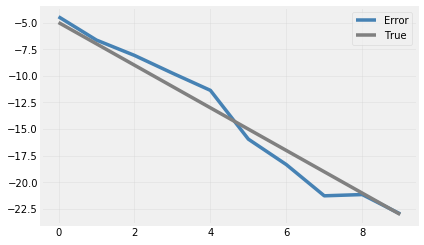

In [10]:
alpha_true, beta_true = -2, -5
time = list(range(10))

y_true = [alpha_true*time[i] + beta_true for i in range(10)]
sigma = 1
meas_err = np.random.normal(loc=0, scale=sigma, size=len(time))
y = y_true + meas_err

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
ax.plot(y, color="steelblue", label="Error", lw=3.5);
ax.plot(y_true, color="gray", label="True", lw=3.5);
ax.grid(alpha=0.25);
ax.legend();

theta = [1, 40]
the acceptance rate for step size of [0.1, 1] is 26.6200


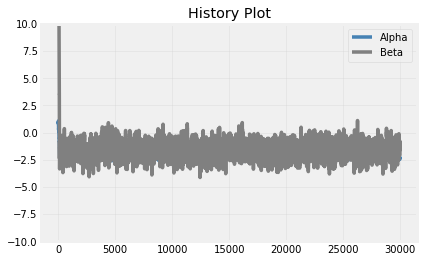

In [12]:
# Imports
import sys
# Run some needed code!
N = 30000
alpha_init = np.random.randint(-50,50)
beta_init = np.random.randint(-50,50)
theta = [alpha_init,beta_init]
lp = logp(theta,time,y)
# Print the theta
print("theta =", theta, file=sys.stderr)
# Define the algorithms variables
theta_best = theta
lp_max = lp
theta_new = [0] * 2
accepts = 0
mcmc_chains = [[0, 0]] * N
step = [0.1, 1]
time = list(range(1, 11))
# Run the algorithm
for i in range(N):
    theta_new = list(stats.norm.rvs(theta, step))
    lp_new = logp(theta_new, time, y)
    lq = lp_new - lp
    lr = math.log(np.random.uniform(0, 1))
    if (lr < lq):
        theta = theta_new
        lp = lp_new
        accepts += 1
        if lp > lp_max:
            theta_best = theta
            lp_max = lp
    mcmc_chains[i] = theta
# Print the acceptance rate
print("the acceptance rate for step size of", step, "is {:.4f}".format(accepts / N*100), file=sys.stderr)
mcmc_chains = np.array(mcmc_chains)
# Plot!!!
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
ax.plot(mcmc_chains[:, 0], color="steelblue", lw=3.5, label='Alpha')
ax.plot(mcmc_chains[:, 1], color="gray", lw=3.5, label='Beta')
plt.title('History Plot');
ax.legend();
ax.grid(alpha=0.25);
ax.set_ylim((-10, 10));

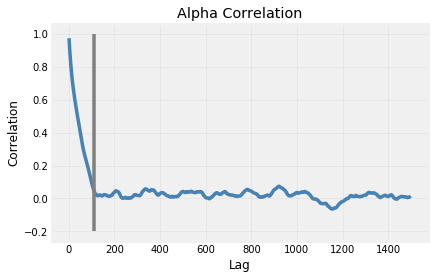

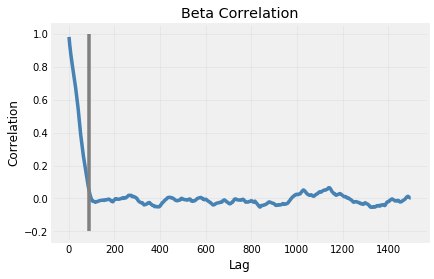

In [13]:
lag1 = plot_graph_alpha(mcmc_chains)
lag2 = plot_graph_beta(mcmc_chains)

In [14]:
print("Alpha lag =", lag1)
print("Beta lag =", lag2)
alpha_est, beta_est = [], []
jump = lag1 if lag1 > lag2 else lag2
for i in range(0, len(mcmc_chains), jump):
    alpha_est.append(mcmc_chains[i][0])
    beta_est.append(mcmc_chains[i][1])
print('Alpha estimate = {:.4f}'.format(np.mean(alpha_est)))
print('Beta estimate = {:.4f}'.format(np.mean(beta_est)))

Alpha lag = 110
Beta lag = 89
Alpha estimate = -2.2319
Beta estimate = -1.4353


### Gelman-Rubin Convergence Diagnostic
---

Random estimate for parameters = [24, 5]


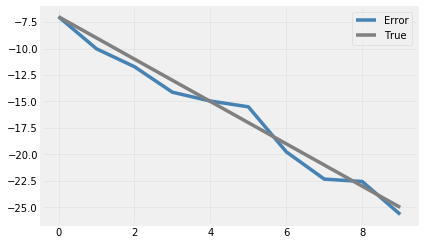

In [15]:
import sys

alpha_true = -2
beta_true = -5
time = list(range(1, 11))

y_true = [alpha_true * time[i] + beta_true for i in range(0, 10)]
sigma = 1
meas_err = np.random.normal(loc=0, scale=sigma, size=len(time))
y = y_true + meas_err

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
ax.plot(y, color="steelblue", lw=3.5, label='Error')
ax.plot(y_true, color="gray", lw=3.5, label='True')
ax.legend();
ax.grid(alpha=0.25);

N = 30000
alpha_init = np.random.randint(-50, 50)
beta_init = np.random.randint(-50, 50)
theta = [alpha_init, beta_init]
print('Random estimate for parameters =', theta, file=sys.stderr)

lp = logp(theta, time, y)
theta_best = theta
lp_max = lp
theta_new = [0] * 2
accepts = 0
mcmc_chains = [[0., 0.]] * N
mcmc_chains = np.array(mcmc_chains)
step = np.array([[.1,0],[0,1]])
time = list(range(1, 11))
sd = (2.38**2)/2

for i in range(N):
    step = sd*(np.cov(np.transpose(mcmc_chains[:i,:]))) if i > 1000 else step
    theta_new = list(np.random.multivariate_normal(mean=theta,cov=step))
    lp_new = logp(theta_new, time, y)
    lq = lp_new - lp
    lr = math.log(np.random.uniform(0, 1))
    if (lr < lq):
        theta = theta_new
        lp = lp_new
        accepts += 1
        if lp > lp_max:
            theta_best = theta
            lp_max = lp
    mcmc_chains[i] = theta

Acceptance Rate = 1.2067


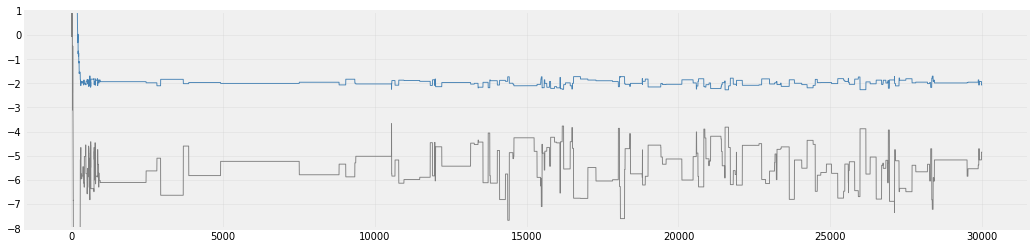

In [16]:
# Imports
import sys
# Print the acceptance rate
print('Acceptance Rate = {:.4f}'.format(accepts / N*100), file=sys.stderr)
# Plot!!!
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4));
ax.plot(mcmc_chains[:, 0], color="steelblue", lw=.9)
ax.plot(mcmc_chains[:, 1], color="gray", lw=.9)
ax.set_ylim(-8,1);
ax.grid(alpha=0.25);

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

Random estimate for parameters = [42, -38]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [-24, 30]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [11, 20]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [33, 41]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [17, 44]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [44, 34]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [14, -2]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [-29, 46]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [-4, 35]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

Random estimate for parameters = [-46, -12]


HBox(children=(IntProgress(value=0, max=30000), HTML(value='')))

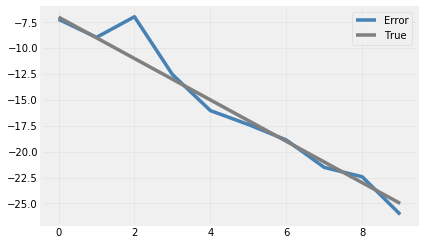

In [17]:
y_true = [alpha_true * time[i] + beta_true for i in range(0, 10)]
sigma = 1
meas_err = np.random.normal(loc=0, scale=sigma, size=len(time))
y = y_true + meas_err

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
ax.plot(y, color="steelblue", lw=3.5, label='Error')
ax.plot(y_true, color="gray", lw=3.5, label='True')
ax.legend();
ax.grid(alpha=0.25);

mcmc_chains = []
N = 30000
m = 10
for i in tnrange(10, desc=''):
    mcmc_chains.append(chain(N))
mcmc_chains = np.array(mcmc_chains)

1.345496631146909
1.345496631146909
1.1699739564193552
1.1147642237997084
1.100785943258196
1.0933776452697619
1.0913489817025588
1.0938487140173712
1.0987232236691413
1.1035474495265323
1.10715243665759
1.1098142174499848
1.111307503342101
1.1108541517592427
1.1084001033878577
1.1043306871278655
1.0991634850202558
1.093737961881521
1.0883997968823234
1.0830558541124389
1.0782210900444176
1.0738877712721064
1.0700370391808964
1.0665773529251932
1.0633962628564952
1.0605056984167724
1.0578981366871312
1.0555061120979594
1.0532974361296215
1.0512629549448071
1.0494026481443417


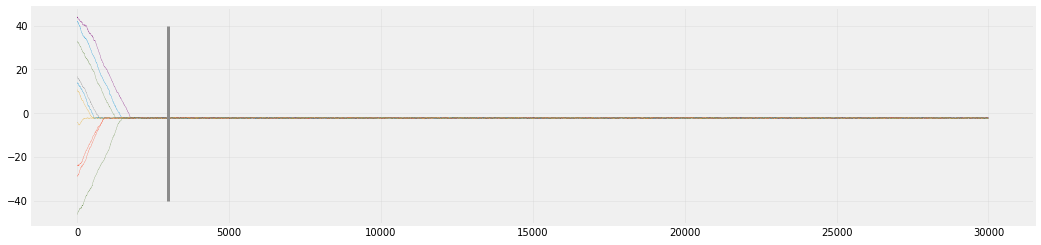

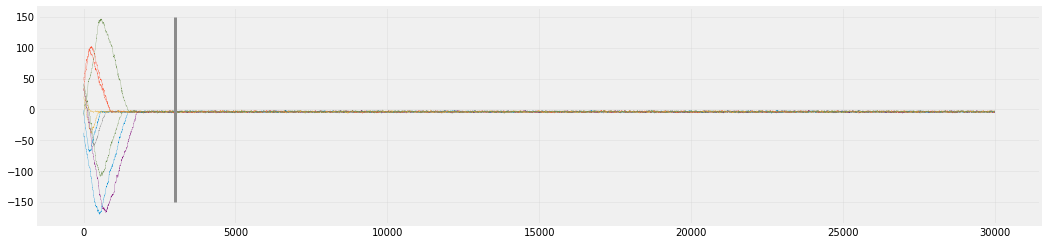

In [18]:
R = (diagnsotic(mcmc_chains[:,0,:]))
burn_in = 1
print(R)
while R >= 1.05:
    R = (diagnsotic(mcmc_chains[:,:burn_in,:]))
    burn_in += 100
    print(R)
R = (diagnsotic(mcmc_chains[:,burn_in:,:]))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4));
for i in range(len(mcmc_chains)):
    ax.plot(mcmc_chains[i,:,0], linewidth=0.25)
ax.plot([burn_in,burn_in],[-40,40], linewidth=3)
ax.grid(alpha=0.25);

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4));
for i in range(len(mcmc_chains)):
    plt.plot(mcmc_chains[i,:,1], linewidth=0.25)
plt.plot([burn_in,burn_in],[-150,150], linewidth=3)
ax.grid(alpha=0.25);

69


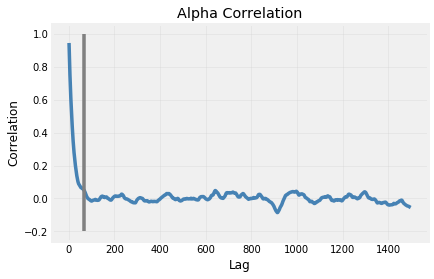

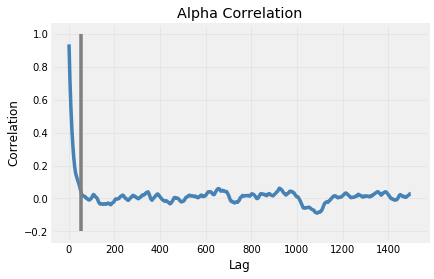

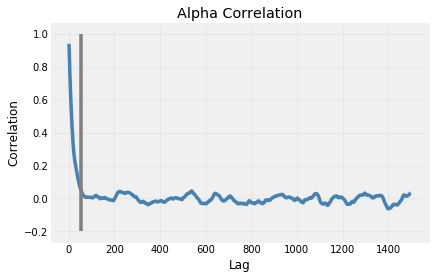

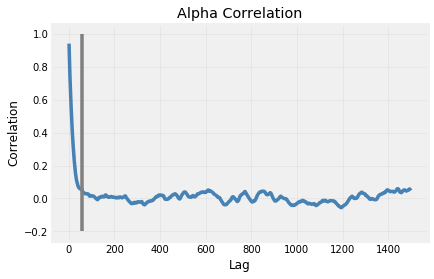

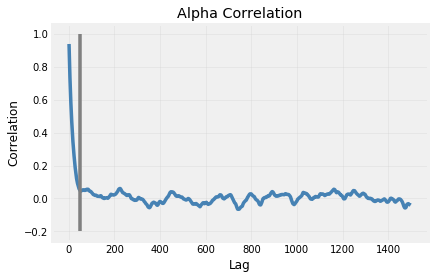

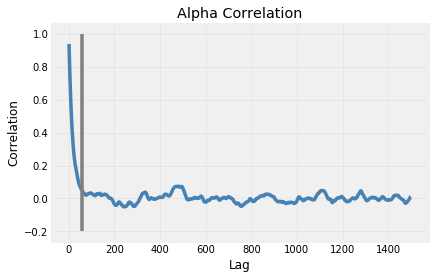

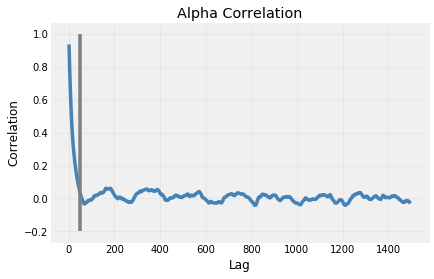

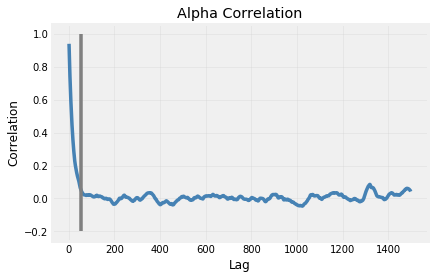

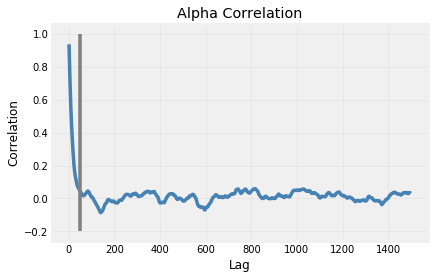

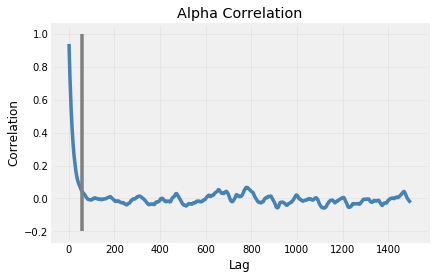

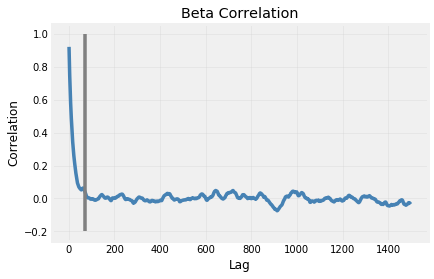

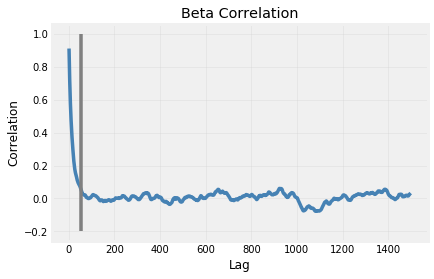

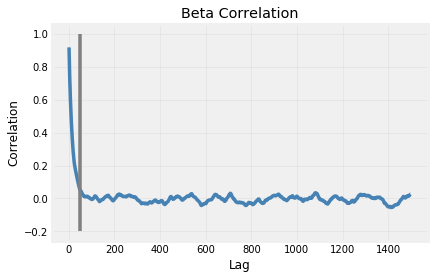

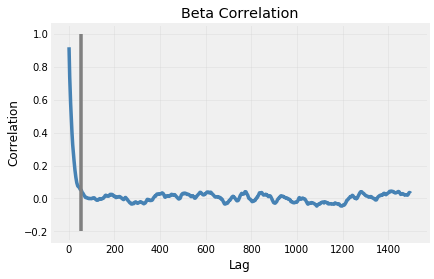

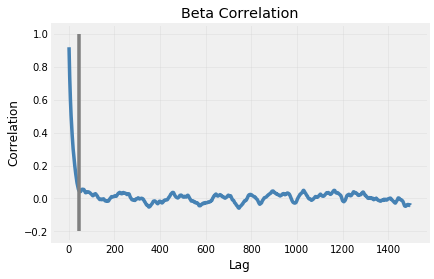

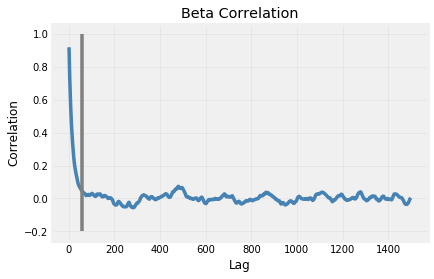

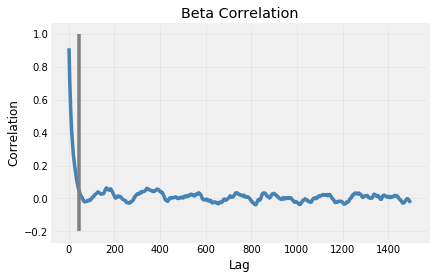

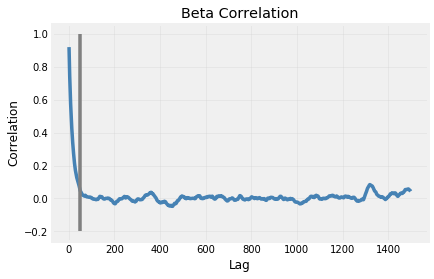

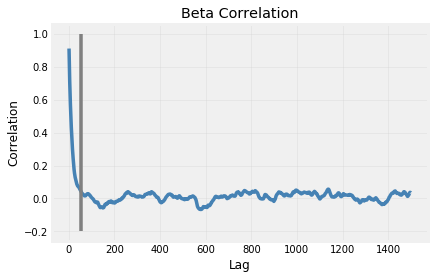

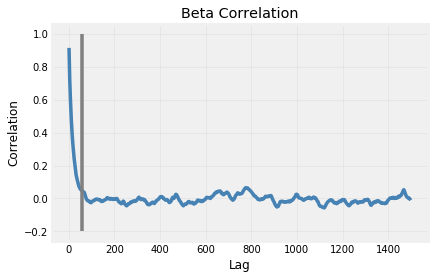

In [19]:
lag1 = [plot_graph_alpha(mcmc_chains[i,burn_in:,:]) for i in range(len(mcmc_chains))]
lag2 = [plot_graph_beta(mcmc_chains[i,burn_in:,:]) for i in range(len(mcmc_chains))]
lag = (np.max(lag1+lag2))
print(lag)
alpha1, beta1 = [], []

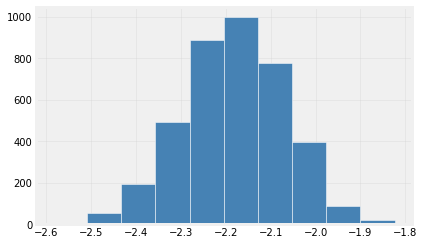

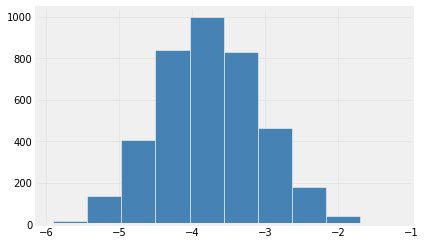

In [20]:
# Calculate the histogram values
alpha_hist = []
for i in range(len(mcmc_chains)):
    for j in range(burn_in,len(mcmc_chains[i]),lag):
        alpha_hist.append(mcmc_chains[i,j,0])
beta_hist = []
for i in range(len(mcmc_chains)):
    for j in range(burn_in,len(mcmc_chains[i]),lag):
        beta_hist.append(mcmc_chains[i,j,1])
# Plot the alpha histogram
plot(type="hist", data=[alpha_hist])
# Plot the beta histogram
plot(type="hist", data=[beta_hist])
#
alpha_CI = [np.percentile(alpha_hist, 5),np.percentile(alpha_hist, 95)]
beta_CI = [np.percentile(beta_hist, 5),np.percentile(beta_hist, 95)]

[-2.3729009610698206, -1.9984372724667838]
[-4.894094022645781, -2.5821764460263945]


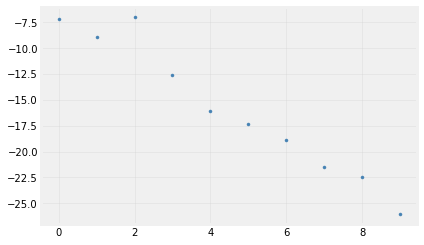

In [21]:
print(alpha_CI)
print(beta_CI)

plot(type="scatter", data=[np.arange(0, len(y)), y], marker=".")

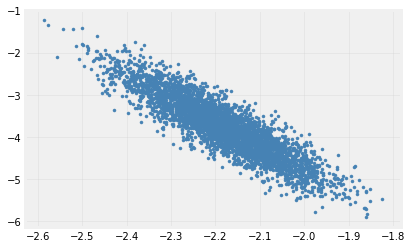

In [22]:
plot(type="scatter", data=[alpha_hist, beta_hist], marker=".")

In [ ]:
import sys

steps = [
    [[0.005, 0], [0, 0.005]],
    [[0.009, 0], [0, 0.009]],
    [[1, 0], [0, .01]],
    [[1, 0], [0, .1]],
    [[.1, 0], [0, .1]],
    [[.2, 0], [0, .2]],
    [[5, 0], [0, .5]],
    [[0.001, 0], [0, 0.001]]
]
time = list(range(1, 11))
# Run the algorithm
for index, step in enumerate(steps):
    print("Running with step size of", step, file=sys.stderr)
    # Run!
    N = 30000
    alpha_init = np.random.randint(-50,50)
    beta_init = np.random.randint(-50,50)
    theta = [alpha_init,beta_init]
    lp = logp(theta,time,y)
    # Define the variables required
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 2
    accepts = 0
    mcmc_chains = [[0, 0]] * N
    # Run some more!
    for i in range(N):
#         theta_new = list(stats.norm.rvs(theta, step))
        theta_new = list(np.random.multivariate_normal(theta, step))
        lp_new = logp(theta_new, time, y)
        lq = lp_new - lp
        lr = math.log(np.random.uniform(0, 1))
        if (lr < lq):
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    # Print the acceptance rate
    print("The acceptance rate for this particular step size is", accepts/N*100, file=sys.stderr)
    mcmc_chains = np.array(mcmc_chains)
    # Plot!!!
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
    ax.plot(mcmc_chains[:, 0], color="steelblue", lw=3.5, label='Alpha')
    ax.plot(mcmc_chains[:, 1], color="gray", lw=3.5, label='Beta')
    plt.title('History Plot')
    ax.legend()
    fig.savefig('history_plots/multivariate-' + str(index + 1))
    alpha = [mcmc_chains[i][0] for i in range(len(mcmc_chains))]
    beta = [mcmc_chains[i][1] for i in range(len(mcmc_chains))]

### Helper Functions
---

In [3]:
def plot(type="", figsize=(6,4), data=[], marker="", color="steelblue"):
    """
    Plotting function that plots stuff for you!
        
    :param type:   the type of plot, expects either "scatter" or "hist"
    :param marker: the marker type used in plot
    :param data:   the data to plot
    """
    import sys
    if type=="scatter":
        if len(data)!=2:
            raise ValueError(u"data needs to be of size 2: got {}".format(len(data)))
        else:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize);
            if marker!="":
                ax.scatter(data[0], data[1], marker=marker, color=color)
            else:
                ax.scatter(data[0], data[1], color=color)
            ax.grid(alpha=0.25);
    if type=="hist":
        if len(data)!=1:
            raise ValueError(u"data needs to be of size 1: got {}".format(len(data)))
            return
        else:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize);
            ax.hist(data[0], color=color, edgecolor="white")
            ax.grid(alpha=0.25);

In [4]:
def logp(theta, time, y, sigma=1, dist="uniform"):
    N = len(time)
    alpha, beta = theta[0], theta[1]
    model = [alpha * time[i] + beta for i in range(0, 10)]
    resid = y - model
    log_likelihood = -N / 2 * math.log(
        2 * math.pi) - N * math.log(sigma) - 1 / 2 * sum(resid**2) / sigma**2
    if dist=="uniform":
        log_prior = np.random.uniform(alpha, beta)
    elif dist=="normal":
        log_prior = np.random.normal(alpha, beta)
    log_posterior = log_likelihood + log_prior
    return log_posterior

In [5]:
def plot_graph_alpha(mcmc_chains):
    alpha = mcmc_chains[:,0]
    cor, r, flag = [], None, True
    for lag in range(1, 1500):
        X, Y = [], []
        X = alpha[:len(alpha) - lag]
        Y = alpha[lag:]
        cor.append(np.corrcoef(X, Y, rowvar=False)[0][1])
        if flag and cor[lag - 1] <= 0.05:
            flag = False
            r = lag
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
    ax.plot(range(1, 1500), cor, color="steelblue", lw=3.5);
    ax.plot([r, r], [-0.2, 1], color="gray", lw=3.5);
    ax.grid(alpha=0.25);
    ax.set_title('Alpha Correlation');
    ax.set_xlabel('Lag');
    ax.set_ylabel('Correlation');
    return r

def plot_graph_beta(mcmc_chains):
    beta = mcmc_chains[:,1]
    cor, r, flag = [], None, True
    for lag in range(1, 1500):
        X, Y = [], []
        X = beta[:len(beta) - lag]
        Y = beta[lag:]
        cor.append(np.corrcoef(X, Y, rowvar=False)[0][1])
        if flag and cor[lag - 1] <= 0.05:
            flag = False
            r = lag
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4));
    ax.plot(range(1, 1500), cor, color="steelblue", lw=3.5);
    ax.plot([r, r], [-0.2, 1], color="gray", lw=3.5);
    ax.grid(alpha=0.25);
    ax.set_title('Beta Correlation');
    ax.set_xlabel('Lag');
    ax.set_ylabel('Correlation');
    return r

In [6]:
import sys

def chain(N=30000):
    time = list(range(1, 11))
    alpha_init = np.random.randint(-50, 50)
    beta_init = np.random.randint(-50, 50)
    theta = [alpha_init, beta_init]
    print('Random estimate for parameters =', theta, file=sys.stderr)

    lp = logp(theta, time, y)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 2
    accepts = 0
    mcmc_chains = [[0., 0.]] * N
    mcmc_chains = np.array(mcmc_chains)
    step = np.array([.1, 1])
    time = list(range(1, 11))
    # Defining variables for Adaptive metropolis Hastings -
    sd = 2.38**2/2

    for i in tqdm_notebook(range(N), desc=''):
        theta_new = list(stats.norm.rvs(theta, step))
        lp_new = logp(theta_new, time, y)
        lq = lp_new - lp
        lr = math.log(np.random.uniform(0, 1))
        if (lr < lq):
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    return mcmc_chains

In [7]:
def diagnsotic(mcmc_chains):
    """
    num_samples = len(mcmc_chains)
    # Calculate between-chain variance
    B = num_samples * np.var(np.mean(mcmc_chains, axis=1), axis=0, ddof=1)
    # Calculate within-chain variance
    W = np.mean(np.var(mcmc_chains, axis=1, ddof=1), axis=0)
    # Estimate of marginal posterior variance
    Vhat = W * (num_samples - 1) / num_samples + B / num_samples

    print('Vhat =', Vhat)
    
    return np.sqrt(Vhat / W)
    """
    
    m = len(mcmc_chains)
    s_j = [np.var(mcmc_chains[i]) for i in range(m)]
    W = 1 / m * np.sum(s_j)
    global_mean = np.mean([np.mean(mcmc_chains[i]) for i in range(m)])
    B = N / (m - 1) * np.sum([(np.mean(mcmc_chains[i]) - global_mean)**2
                              for i in range(m)])
    Var = (1 - 1/N)*W + 1/N*B
    return np.sqrt(Var/W)